In [ ]:
# make sure to install this package before running:
#!pip install sodapy
#!pip install scikit-learn
#!pip install statsmodels
#!pip install folium
#!pip install imblearn
#!pip install joblib
#!pip install geopandas

##if the libraries are not compatible, you might get an error --
#ensure compatible version of the two:
#!pip install -U scikit-learn imbalanced-learn

In [112]:
import pandas as pd
from sklearn.model_selection import train_test_split
import folium
from folium.plugins import HeatMap
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from folium.features import GeoJsonTooltip
import geopandas as gpd
import matplotlib.pyplot as plt

In [209]:
# Load the SF data
file_path = 'data/SF_Crime_Report_cleaned.csv'
data = pd.read_csv(file_path)

In [210]:
# Function to calculate the 'Hotspot' column
def calculate_hotspot(data):
    mean_30_days = data['Total_Incidents_All'].rolling(window=30).mean().shift(1)
    std_30_days = data['Total_Incidents_All'].rolling(window=30).std().shift(1)
    next_day_incidents = data['Total_Incidents_All'].shift(-1)
    hotspot = (next_day_incidents > (mean_30_days + std_30_days)).astype(int)
    return hotspot


# PReprocess Data

In [211]:

data['Incident_Date'] = pd.to_datetime(data['Incident_Date'])

# Getting the unique police districts
districts = data['Police_District'].unique()

preprocessed_data = {}

for district in districts:
    print(f"Preprocessing data for Police District: {district}")
    data_district = data[data['Police_District'] == district].copy()

    # Aggregating incidents daily, counting the number of incidents of each type
    daily_totals = data_district.groupby('Incident_Date')['Incident_Category'].value_counts().unstack(fill_value=0)
    daily_totals['Total_Incidents_All'] = daily_totals.sum(axis=1)

    # Adding temporal and lag features
    daily_totals['Incident_Day_of_Week'] = daily_totals.index.dayofweek
    daily_totals['Month'] = daily_totals.index.month
    for lag in range(1, lags + 1):
        daily_totals[f'Incidents_Lag{lag}'] = daily_totals['Total_Incidents_All'].shift(lag)

    # Applying the function to calculate the 'Hotspot' column
    daily_totals['Hotspot'] = calculate_hotspot(daily_totals)
    daily_totals.dropna(inplace=True)

    # Store the preprocessed data
    preprocessed_data[district] = daily_totals


Preprocessing data for Police District: Central
Preprocessing data for Police District: Bayview
Preprocessing data for Police District: Northern
Preprocessing data for Police District: Southern
Preprocessing data for Police District: Mission
Preprocessing data for Police District: Richmond
Preprocessing data for Police District: Taraval
Preprocessing data for Police District: Park
Preprocessing data for Police District: Tenderloin
Preprocessing data for Police District: Ingleside
Preprocessing data for Police District: Out of SF


# Train Models

In [212]:
data.head()

,Incident_Date,Incident_Time,Incident_Year,Incident_Day_of_Week,Incident_Category,Police_District,Latitude,Longitude,Neighborhoods,Resolution,...,Resolution_Cite_or_Arrest_Adult,Resolution_Exceptional_Adult,Resolution_Open_or_Active,Resolution_Unfounded,Morning,Afternoon,Night,Is_Arrest,Number_Arrests_7days,Number_Arrests_Previous_Day
0,2022-06-27,1900-01-01 12:00:00,2022,Monday,Lost Property,Central,37.787359,-122.408227,19.0,Open or Active,...,0,0,1,0,1,0,0,0,349,41
1,2023-03-16,1900-01-01 17:30:00,2023,Thursday,Assault,Bayview,37.762290,-122.401324,54.0,Open or Active,...,0,0,1,0,0,1,0,0,475,95
2,2023-03-21,1900-01-01 15:50:00,2023,Tuesday,Non-Criminal,Northern,37.787038,-122.418271,50.0,Open or Active,...,0,0,1,0,0,1,0,0,484,62
3,2021-08-22,1900-01-01 09:40:00,2021,Sunday,Warrant,Northern,37.793977,-122.429804,102.0,Open or Active,...,0,0,1,0,1,0,0,0,371,47
4,2022-07-02,1900-01-01 22:53:00,2022,Saturday,Assault,Bayview,37.719298,-122.390020,88.0,Open or Active,...,0,0,1,0,0,0,1,0,415,65


In [213]:
import pandas as pd

# Convert 'Incident_Date' to datetime if it's not already
data['Incident_Date'] = pd.to_datetime(data['Incident_Date'])

# Sort the DataFrame by 'Incident_Date'
data = data.sort_values('Incident_Date')

# Calculate the total number of incidents for each date
data['Total_Number_Incidents'] = data.groupby('Incident_Date')['Incident_Category'].transform('count')

# To ensure each date is represented only once, we can create a new DataFrame
daily_data = data[['Incident_Date', 'Total_Number_Incidents']].drop_duplicates()

# Set 'Incident_Date' as the index
daily_data.set_index('Incident_Date', inplace=True)

# Calculate the 30-day rolling mean
daily_data['mean_30_days'] = daily_data['Total_Number_Incidents'].rolling(window=30).mean()

# Drop NaN values
daily_data = daily_data.dropna()

daily_data = pd.DataFrame(daily_data).reset_index()
daily_data['Incident_Date'] = pd.to_datetime(daily_data['Incident_Date'])

# Filter to keep only rows from the year 2023
daily_data = daily_data[daily_data['Incident_Date'].dt.year == 2022]

daily_data


,Incident_Date,Total_Number_Incidents,mean_30_days
1432,2022-01-01,426,328.633333
1433,2022-01-02,279,325.033333
1434,2022-01-03,265,322.066667
1435,2022-01-04,291,319.966667
1436,2022-01-05,325,318.833333
...,...,...,...
1792,2022-12-27,350,335.133333
1793,2022-12-28,364,336.733333
1794,2022-12-29,355,337.700000
1795,2022-12-30,349,337.500000


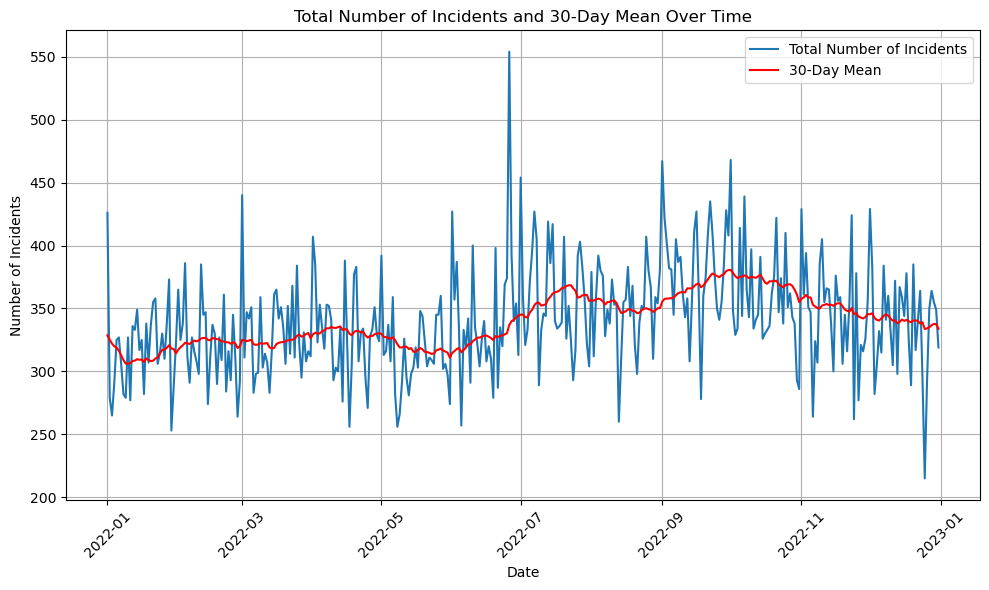

In [214]:

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(daily_data['Incident_Date'], daily_data['Total_Number_Incidents'], label='Total Number of Incidents')
plt.plot(daily_data['Incident_Date'], daily_data['mean_30_days'], label='30-Day Mean', color='red')
plt.title('Total Number of Incidents and 30-Day Mean Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [124]:
daily_totals.columns

Index(['Arson', 'Assault', 'Burglary', 'Case Closure', 'Courtesy Report',
       'Disorderly Conduct', 'Drug Offense', 'Drug Violation', 'Embezzlement',
       'Forgery And Counterfeiting', 'Fraud', 'Homicide',
       'Human Trafficking (A), Commercial Sex Acts',
       'Human Trafficking (B), Involuntary Servitude', 'Larceny Theft',
       'Lost Property', 'Malicious Mischief', 'Miscellaneous Investigation',
       'Missing Person', 'Motor Vehicle Theft', 'Motor Vehicle Theft?',
       'Non-Criminal', 'Offences Against The Family And Children', 'Other',
       'Other Miscellaneous', 'Other Offenses', 'Rape', 'Recovered Vehicle',
       'Robbery', 'Sex Offense', 'Stolen Property', 'Suspicious Occ',
       'Traffic Collision', 'Traffic Violation Arrest', 'Vandalism',
       'Vehicle Impounded', 'Warrant', 'Weapons Carrying Etc',
       'Weapons Offence', 'Weapons Offense', 'Total_Incidents_All',
       'Incident_Day_of_Week', 'Month', 'Incidents_Lag1', 'Incidents_Lag2',
       'Incident

In [21]:
import joblib

trained_models = {}

for district, data_district in preprocessed_data.items():
    print(f"Training model for Police District: {district}")

    # Model training and evaluation
    X = data_district.drop(columns=['Hotspot'])
    y = data_district['Hotspot']

    # Handling class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

    # Random Forest with GridSearchCV
    param_grid_rf = {'n_estimators': [50, 100, 200, 500], 'max_depth': [None, 10, 20]}
    # Gradient Descent with GridSearchCV
    param_grid_gb = {'n_estimators': [50, 100, 200, 500], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 10]}
    

    # Random Forest and Gradient Boosting training
    rf_model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, n_jobs=-1)
    gb_model = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=5, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    gb_model.fit(X_train, y_train)

    # Save the models for this district
    trained_models[district] = {'RandomForest': rf_model.best_estimator_, 
                                'GradientBoosting': gb_model.best_estimator_,
                                'X_test': X_test,
                                'y_test': y_test}


Training model for Police District: Central
Training model for Police District: Bayview
Training model for Police District: Northern
Training model for Police District: Southern
Training model for Police District: Mission
Training model for Police District: Richmond
Training model for Police District: Taraval
Training model for Police District: Park
Training model for Police District: Tenderloin
Training model for Police District: Ingleside
Training model for Police District: Out of SF


## Save model for future use

In [23]:
#Save the models to disk for future use
for district, models in trained_models.items():
    joblib.dump(models['RandomForest'], f'models/rf_model_{district}.pkl')
    joblib.dump(models['GradientBoosting'], f'models/gb_model_{district}.pkl')
    

# Cross Validation & Predictions
## Option 1:  Run Performance Metrics for entire test data

In [34]:
# # Load or preprocess the data
# X_test = X_test
# y_test = y_test


for district in districts:
    print(f"Predicting hotspots for Police District: {district}")

    # Load the test data for the district
    X_test = trained_models[district]['X_test']
    y_test = trained_models[district]['y_test']

    #Load trained model
    rf_model = joblib.load(f'models/rf_model_{district}.pkl')
    gb_model = joblib.load(f'models/gb_model_{district}.pkl')

    # Make predictions with the loaded models
    rf_predictions = trained_models[district]['RandomForest'].predict(X_test)
    gb_predictions = trained_models[district]['GradientBoosting'].predict(X_test)

    # Post-process predictions to identify hotspots
    rf_predictions = rf_model.predict(X_test)
    print("Random Forest Classifier:")
    print(f"Accuracy: {accuracy_score(y_test, rf_predictions)}")
    print("Classification Report:")
    print(classification_report(y_test, rf_predictions))

    gb_predictions = gb_model.predict(X_test)
    print("Gradient Boosting Classifier:")
    print(f"Accuracy: {accuracy_score(y_test, gb_predictions)}")
    print("Classification Report:")
    print(classification_report(y_test, gb_predictions))

Predicting hotspots for Police District: Central
Random Forest Classifier:
Accuracy: 0.9061624649859944
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       359
           1       0.93      0.87      0.90       355

    accuracy                           0.91       714
   macro avg       0.91      0.91      0.91       714
weighted avg       0.91      0.91      0.91       714

Gradient Boosting Classifier:
Accuracy: 0.9019607843137255
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       359
           1       0.90      0.90      0.90       355

    accuracy                           0.90       714
   macro avg       0.90      0.90      0.90       714
weighted avg       0.90      0.90      0.90       714

Predicting hotspots for Police District: Bayview
Random Forest Classifier:
Accuracy: 0.9046961325966851
Classification Report:
          

# Option 2: Run Hotspot predictions for next day > Districts HeatMap

In [42]:
# Example new data row (ensure it's preprocessed correctly)
# just select 1 row of the X_test
#x_test_one_row = trained_models['Bayview']['X_test'].iloc[[0, ]]
#I can test with the y of that row
#y_print_one_row = trained_models['Bayview']['y_test'].iloc[[0, ]]

hotspot_predictions = {}

for district in districts:
    # Load the test data for the district
    X_test = trained_models[district]['X_test']
    
    # Select one row and convert to DataFrame with column names
    x_test_one_row = X_test.iloc[[0]].copy()

    model = trained_models[district]['RandomForest']  # or GradientBoosting
    # Make prediction using DataFrame
    prediction = model.predict(x_test_one_row)
    hotspot_predictions[district] = prediction[0]  # Binary prediction: 0 or 1


In [56]:
# upper case for district names to match geojson
hotspot_predictions_capitalized =  {k.upper(): v for k, v in hotspot_predictions.items()}
hotspot_predictions_capitalized

{'CENTRAL': 0,
 'BAYVIEW': 1,
 'NORTHERN': 0,
 'SOUTHERN': 0,
 'MISSION': 1,
 'RICHMOND': 0,
 'TARAVAL': 1,
 'PARK': 1,
 'TENDERLOIN': 1,
 'INGLESIDE': 0,
 'OUT OF SF': 0}

## Not very robust map with `pyplot`

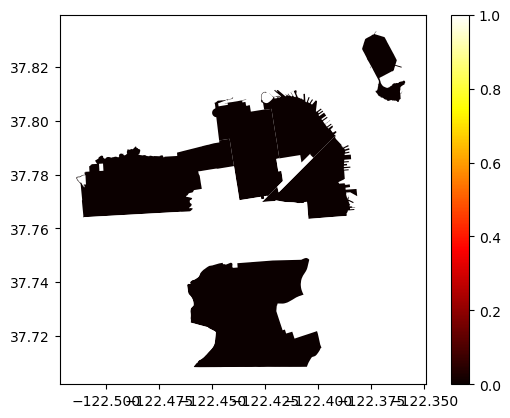

In [117]:
# Load the geographical boundaries
district_boundaries = gpd.read_file('data/Current_Police_Districts_GEOJSON.geojson')

# Map predictions to each district
district_boundaries['hotspot'] = district_boundaries['district'].map(hotspot_predictions_capitalized)

# Plot
fig, ax = plt.subplots(1, 1)
district_boundaries.plot(column='hotspot', ax=ax, legend=True, cmap='hot')
plt.show()


In [118]:
hotspot_predictions_capitalized

{'CENTRAL': 0,
 'BAYVIEW': 1,
 'NORTHERN': 0,
 'SOUTHERN': 0,
 'MISSION': 1,
 'RICHMOND': 0,
 'TARAVAL': 1,
 'PARK': 1,
 'TENDERLOIN': 1,
 'INGLESIDE': 0,
 'OUT OF SF': 0}

## HEATMAP: Centroids Ditricts 

In [119]:
# Load GeoJSON file
gdf = gpd.read_file('data/Current_Police_Districts_GEOJSON.geojson')

# Check the current CRS
print(gdf.crs)

# If it's in a geographic CRS (like WGS84 - EPSG:4326)
gdf = gdf.to_crs(epsg=4326)

# Now calculate the centroid
gdf['centroid'] = gdf['geometry'].centroid

# Extract the latitude and longitude of each centroid
gdf['centroid_lat'] = gdf['centroid'].y
gdf['centroid_lon'] = gdf['centroid'].x

# Add the predictions to the GeoDataFrame
gdf['prediction'] = gdf['district'].apply(lambda x: hotspot_predictions_capitalized[x])

# Create a list of [latitude, longitude, prediction] for the heatmap
heatmap_data = gdf[['centroid_lat', 'centroid_lon', 'prediction']].values.tolist()

# Initialize the map on San Francisco
map_sf = folium.Map(location=[37.7749, -122.4194], zoom_start=12)

# Add the heatmap to the map
HeatMap(heatmap_data).add_to(map_sf)

# Save to html
map_sf.save('sf_districts_heatmap.html')

EPSG:4326


/var/folders/l3/h56ll3s97r3bp825gbh1f4q80000gq/T/ipykernel_23353/3959774868.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf['geometry'].centroid


## HEATMAP: Colored Map Ditricts 

In [120]:
# Load GeoJSON file
gdf = gpd.read_file('data/Current_Police_Districts_GEOJSON.geojson')

# Ensure the GeoDataFrame is in the correct CRS
gdf = gdf.to_crs(epsg=4326)

# Add the predictions to the GeoDataFrame
gdf['prediction'] = gdf['district'].apply(lambda x: hotspot_predictions_capitalized.get(x.upper(), 0))

# Convert to JSON format
gdf_json = gdf.to_json()

# Initialize the map on San Francisco
map_sf = folium.Map(location=[37.7749, -122.4194], zoom_start=12)

# Function to color the district based on the prediction
def style_function(feature):
    return {
        'fillColor': 'red' if feature['properties']['prediction'] == 1 else 'green',
        'color': 'black',
        'weight': 1.5,
        'fillOpacity': 0.5,
    }

# Add the GeoJSON to the map with the style function
folium.GeoJson(
    gdf_json,
    style_function=style_function
).add_to(map_sf)

# Save to html
map_sf.save('sf_districts_colored_map.html')


## HEATMAP: Final District Map Labeled

In [121]:
# Load GeoJSON file (in data folder)
gdf = gpd.read_file('data/Current_Police_Districts_GEOJSON.geojson')

# Project to EPSG:4326
gdf = gdf.to_crs(epsg=4326)

# Add prediction data to gdf for coloring
gdf['prediction'] = gdf['district'].apply(lambda x: hotspot_predictions_capitalized.get(x.upper(), 0))

# Initialize the map on San Francisco
map_sf = folium.Map(location=[37.7749, -122.4194], zoom_start=12)

# Function to convert prediction values to "Yes" or "No"
def prediction_text(value):
    return "Yes" if value == 1 else "No"

# Function to apply color based on prediction value
def style_function(feature):
    prediction_value = feature['properties']['prediction_text']
    return {
        'fillColor': 'red' if prediction_value == 'Yes' else 'green',
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.5,
    }

# Add the predictions as "Yes" or "No" to the GeoDataFrame for use in the tooltip
gdf['prediction_text'] = gdf['prediction'].apply(prediction_text)

# Tooltip fields for labels and fovering 
tooltip = GeoJsonTooltip(
    fields=['district', 'prediction_text'],
    aliases=['District:', 'Hotspot Prediction:'],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #FFFFEF;
        opacity: 0.50;
        border: 1px solid black;
        border-radius: 3px;
    """,
    max_width=800,
)

#Generate Map
folium.GeoJson(
    gdf,
    style_function=style_function,
    tooltip=tooltip
).add_to(map_sf)

# Prepare heatmap data (using centroid for illustration)
heatmap_data = [
    [point.y, point.x, prediction] 
    for point, prediction in zip(gdf.centroid, gdf['prediction'])
    if prediction == 1  # assuming you only want to map hotspots
]

# Add heatmap layer on top of the colored districts
HeatMap(heatmap_data, min_opacity=0.5).add_to(map_sf)

# Save to HTML to view in a browser
map_sf.save('sf_districts_combined_map.html')


/var/folders/l3/h56ll3s97r3bp825gbh1f4q80000gq/T/ipykernel_23353/52200992.py:56: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for point, prediction in zip(gdf.centroid, gdf['prediction'])
